In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint
from time import time
import logging
from sklearn.model_selection import train_test_split
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing

#SK-learn libraries for transformation and pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer


In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class PipelineEstimator(BaseEstimator, TransformerMixin):
    """Define the necessary methods"""

    def __init__(self):
        pass


    def fit(self, X, y = None):
        return self


    def transform(self, X, y = None):
        return X


class ProcessNumerical(PipelineEstimator):

    def __init__(self, cols_to_square = (), cols_to_log = ()):
        self.cols_to_square = cols_to_square
        self.cols_to_log = cols_to_log


    def square(self, X):
        for col in self.cols_to_square:
            X[col + '_sq'] = np.square(X[col])
        return X


    def log(self, X):
        for col in self.cols_to_log:
            X[col + '_log'] = np.log(X[col])
        return X


    def transform(self, X, y = None):
        """Square or log given numerical columns"""
        X = self.square(X)
        X = self.log(X)

        return X


class DateFormatter(PipelineEstimator):
    """Parse datetime into its component parts"""

    def __init__(self):
        pass


    def transform(self, X, y = None):
        """Split the datetime into its component parts."""
        X['year'] = pd.DatetimeIndex(X['datetime']).year
        X['month'] = pd.DatetimeIndex(X['datetime']).month
        X['hour'] = pd.DatetimeIndex(X['datetime']).hour
        X['weekday'] = pd.DatetimeIndex(X['datetime']).weekday
#         # Change the index to datetime
#         X.set_index(pd.DatetimeIndex(X['datetime']), inplace=True)
#         # Create new day and time related features
#         X['date'] = pd.DatetimeIndex(X['datetime']).strftime("%Y%m%d")
#         X['day'] = pd.DatetimeIndex(X['datetime']).strftime("%j")
#         X['month1'] = pd.DatetimeIndex(X['datetime']).strftime("%m")
#         # X['month2'] = pd.DatetimeIndex(X['datetime']).strftime("%B")
#         X['year'] = pd.DatetimeIndex(X['datetime']).strftime("%Y")
#         X['hour'] = pd.DatetimeIndex(X['datetime']).strftime("%H")
#         X['dow1'] = pd.DatetimeIndex(X['datetime']).strftime("%w")
#         # X['dow2'] = pd.DatetimeIndex(X['datetime']).strftime("%A")
#         X['woy'] = pd.DatetimeIndex(X['datetime']).strftime("%W")
        return X



class SelectCols(PipelineEstimator):
    """Return only specified columnss"""

    def __init__(self, cols = (), invert = False):
        self.cols = cols
        self.invert = invert


    def transform(self, X, y = None):
        mask = np.array([True if col in self.cols else False for col in X.columns])
        if self.invert:
            mask = np.invert(mask)
        return X.loc[:, mask]


class BinarySplitter(PipelineEstimator):
    """Binarize a feature and add that as a new feature"""

    def __init__(self, col, threshold, new_name = None):
        """Split col based on threshold"""
        self.col = col
        self.threshold = threshold
        self.new_name = new_name or col + "_bin"


    def transform(self, X, y = None):
        X[self.new_name] = X[self.col] >= self.threshold
        return X


class PassFilter(PipelineEstimator):
    """Low, hi, or bandpass filter
    If you supply:
    a lowerbound (lb): you will get a high pass filter.
    an upperbound (ub): you will get a low pass filter.
    both lb and ub: you will get a band pass filter.
    
    You may specify the values you want to replace values that do not
    pass. If neither the replacements nor the replacement style are
    supplied, then the low values will be replaced with the lb, and
    high values with the ub.
    If you specify the replacement style to be:
    'med': Values will be replaced by the median of the values that do
    not pass on that side
    'mean': Ditto, but with the mean
    'minmax': The minimum value out of the low values, and the max of
    the high values
    """

    def __init__(self, col, lb = None, ub = None, new_name = None,
                 lb_replacement = None, ub_replacement = None,
                 replacement_style = None):
        self.col = col
        self.lb  = lb
        self.ub  = ub
        self.new_name = new_name or col + "_filt"
        self.lb_replacement = lb_replacement
        self.ub_replacement = ub_replacement
        self.replacement_style = replacement_style


    def fit(self, X, y = None):
        """Determine replacement values if none given"""
        if self.lb and self.lb_replacement is None:

            if self.replacement_style == 'min_max':
                self.lb_replacement = np.min(X[self.col])

            elif self.replacement_style == 'med':
                med = np.nanmedian(
                    np.where(X[self.col] < self.lb, X[self.col], np.nan))
                self.lb_replacement = med

            elif self.replacement_style == 'mean':
                mean = np.nanmean(
                    np.where(X[self.col] < self.lb, X[self.col], np.nan))
                self.lb_replacement = mean

            else:
                self.lb_replacement = self.lb


        if self.ub and self.ub_replacement is None:

            if self.replacement_style == 'min_max':
                self.ub_replacement = np.max(X[self.col])

            elif self.replacement_style == 'med':
                med = np.nanmedian(
                    np.where(X[self.col] > self.ub, X[self.col], np.nan))
                self.ub_replacement = med

            elif self.replacement_style == 'mean':
                mean = np.nanmean(
                    np.where(X[self.col] > self.ub, X[self.col], np.nan))
                self.ub_replacement = mean

            else:
                self.ub_replacement = self.ub

        return self
        
    def transform(self, X, y = None):
        X[self.new_name] = X[self.col]

        if self.lb:
            X[self.new_name] = np.where(
                X[self.new_name] < self.lb, self.lb_replacement, X[self.new_name]
            )

        if self.ub:
            X[self.new_name] = np.where(
                X[self.new_name] > self.ub, self.ub_replacement, X[self.new_name]
            )

        return X

In [7]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [8]:
features = ['season', 'holiday', 'workingday', 'weather',
        'temp', 'atemp', 'humidity', 'windspeed', 'year',
         'month', 'weekday', 'hour']

# Define pipeline
categorical = ('season', 'holiday', 'workingday', )
# datetime isn't numerical, but needs to be in the numeric branch
numerical = ('datetime', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',)
pipeline = Pipeline([
    # process cat & num separately, then join back together
    ('union', FeatureUnion([ 
        ('categorical', Pipeline([
            ('select_cat', SelectCols(cols = categorical)),
            ('onehot', OneHotEncoder()),    
        ])),    
        ('numerical', Pipeline([
            ('select_num', SelectCols(cols = numerical)),
            ('date', DateFormatter()),
            ('drop_datetime', SelectCols(cols = ('datetime'), invert = True)),
            ('drop_weather', SelectCols(cols = ('weather'), invert = True)),
#             ('temp', fe.ProcessNumerical(cols_to_square = ('temp', 'atemp', 'humidity'))),
            # ('bad_weather', fe.BinarySplitter(col = 'weather', threshold = 2)),
            # ('filter', fe.PassFilter(col='atemp', lb = 15, replacement_style = 'mean'))
            ('scale', StandardScaler()),    
        ])),    
    ])),
    ('to_dense', preprocessing.FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
])

#Helper function to calculate root mean squared error
def get_RMSE(actual_values, predicted_values):
    n = len(actual_values)
    RMSE = np.sqrt(np.sum(((np.log(predicted_values + 1) - np.log(actual_values + 1)) ** 2) / n))
    return RMSE

#create custom scorer
RMSE_scorer = make_scorer(get_RMSE, greater_is_better = False)

# Split into Dev and Train data and find best parameters
features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered']]    
def train_dev_model_search(registered_or_casual,parameters):
    print("Performing grid search...")
    t0 = time()
    gs = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=1, scoring=RMSE_scorer)
    gs.fit(train_data[features], train_data[registered_or_casual])
    print("Best parameters set:")
    best_param = gs.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_param[param_name]))
    predicted_y = gs.predict(dev_data[features])
    print "GridSearch RMSE " + str(gs.best_score_)
    rmse = get_RMSE(actual_values = dev_data[registered_or_casual], predicted_values = predicted_y)
    print "RMSE: ", str(rmse)
    print("Done in %0.3fs" % (time() - t0))
    print ""

In [11]:
	
# Test for casual and registered separately
# parameters = {
#     'clf__n_estimators': (70,80,90,100,110,120,),
#     'clf__learning_rate': (0.05,),
#     'clf__max_depth': (10,),
#     'clf__min_samples_leaf': (20,),
# }

row_format = "{:>10}" *(6) # Code to help with print display

train_data = train_df[pd.DatetimeIndex(train_df['datetime']).day <= 16]
dev_data = train_df[pd.DatetimeIndex(train_df['datetime']).day > 16]

features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered']] 

fe_train_data = pipeline.fit_transform(train_data[features])
fe_dev_data = pipeline.fit_transform(dev_data[features])

print fe_train_data

/Users/kwheatley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kwheatley/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[ 1.          0.          0.         ..., -1.60062051 -1.66854635
   0.98806716]
 [ 1.          0.          0.         ..., -1.60062051 -1.52393238
   0.98806716]
 [ 1.          0.          0.         ..., -1.60062051 -1.37931841
   0.98806716]
 ..., 
 [ 0.          0.          0.         ...,  1.59069055  1.36834704
   1.48812388]
 [ 0.          0.          0.         ...,  1.59069055  1.51296101
   1.48812388]
 [ 0.          0.          0.         ...,  1.59069055  1.65757499
   1.48812388]]


n_estimator        70      RMSE     0.573   Runtime     2.993
n_estimator        75      RMSE     0.562   Runtime     2.978
n_estimator        80      RMSE     0.554   Runtime     2.891
n_estimator        85      RMSE      0.56   Runtime      3.07
n_estimator        90      RMSE     0.548   Runtime     3.558
n_estimator        95      RMSE     0.538   Runtime     3.632
n_estimator       100      RMSE     0.538   Runtime     3.661
n_estimator       105      RMSE      0.54   Runtime     3.766
n_estimator       110      RMSE     0.538   Runtime       4.0
n_estimator       115      RMSE     0.541   Runtime     3.847
n_estimator       120      RMSE     0.541   Runtime     4.336
n_estimator       125      RMSE     0.547   Runtime     3.911
n_estimator       130      RMSE      0.56   Runtime     4.385
n_estimator       135      RMSE     0.543   Runtime     4.207
n_estimator       140      RMSE     0.543   Runtime     5.062


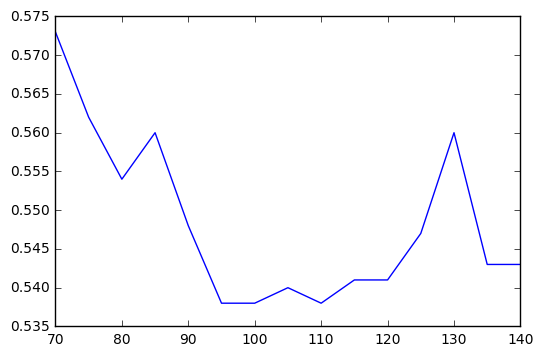

In [10]:
registered_or_casual='casual'
n_estimators=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140]

rmse_list=[]
for i in n_estimators:
    t0 = time()
    gb = GradientBoostingRegressor(
                      n_estimators=i,
                      learning_rate=0.05,
                      max_depth=10,                      
                      min_samples_leaf=20,
                      random_state=2)
    gb.fit(fe_train_data, train_data[registered_or_casual])
    predicted_y = gb.predict(fe_dev_data)
    rmse = get_RMSE(actual_values = dev_data[registered_or_casual], predicted_values = predicted_y)
    rmse_list.append(round(rmse,3))
    print row_format.format("n_estimator", i, "RMSE", round(rmse,3),
                            "Runtime", round((time() - t0),3))
plt.plot(n_estimators,rmse_list)
plt.show()

learning_rate      0.01      RMSE     1.075   Runtime     5.399
learning_rate      0.02      RMSE     0.727   Runtime     4.996
learning_rate      0.03      RMSE     0.577   Runtime     5.418


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in log


learning_rate      0.04      RMSE     0.549   Runtime     4.552
learning_rate     0.045      RMSE     0.536   Runtime      4.85
learning_rate      0.05      RMSE      0.55   Runtime     4.615
learning_rate     0.055      RMSE     0.543   Runtime     4.299
learning_rate      0.06      RMSE     0.548   Runtime     4.252
learning_rate      0.07      RMSE     0.558   Runtime     4.028
learning_rate      0.08      RMSE     0.542   Runtime     3.898
learning_rate      0.09      RMSE     0.571   Runtime      3.61
learning_rate       0.1      RMSE      0.57   Runtime     3.447
learning_rate       0.2      RMSE     0.598   Runtime     2.886
learning_rate       0.3      RMSE     0.655   Runtime     2.999
learning_rate       0.4      RMSE     0.676   Runtime     3.053


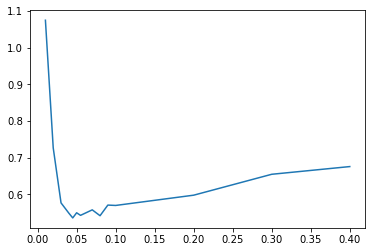

In [108]:
registered_or_casual='casual'
learning_rate=[.01,.02,.03,.04,.045,.05,.055,.06,.07,.08,.09,.1,.2,.3,.4]

rmse_list=[]
for i in learning_rate:
    t0 = time()
    gb = GradientBoostingRegressor(
                      n_estimators=115,
                      learning_rate=i,
                      max_depth=10,                      
                      min_samples_leaf=20,
                      random_state=2)
    gb.fit(fe_train_data, train_data[registered_or_casual])
    predicted_y = gb.predict(fe_dev_data)
    rmse = get_RMSE(actual_values = dev_data[registered_or_casual], predicted_values = predicted_y)
    rmse_list.append(round(rmse,3))
    print row_format.format("learning_rate", i, "RMSE", round(rmse,3),
                            "Runtime", round((time() - t0),3))
plt.plot(learning_rate,rmse_list)
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in log


 max_depth         1      RMSE      1.07   Runtime     0.203
 max_depth         2      RMSE     0.856   Runtime     0.339
 max_depth         3      RMSE     0.778   Runtime     0.564
 max_depth         4      RMSE     0.714   Runtime     0.841
 max_depth         5      RMSE     0.702   Runtime     1.307
 max_depth         6      RMSE     0.599   Runtime     1.849
 max_depth         7      RMSE     0.573   Runtime     2.374
 max_depth         8      RMSE     0.555   Runtime     3.105
 max_depth         9      RMSE     0.543   Runtime     3.733
 max_depth        10      RMSE      0.55   Runtime     4.383
 max_depth        11      RMSE     0.546   Runtime       5.0
 max_depth        12      RMSE     0.539   Runtime     5.481
 max_depth        13      RMSE     0.551   Runtime     5.771
 max_depth        14      RMSE     0.539   Runtime     5.836
 max_depth        15      RMSE     0.557   Runtime     6.091
 max_depth        16      RMSE     0.547   Runtime     6.258
 max_depth        17    

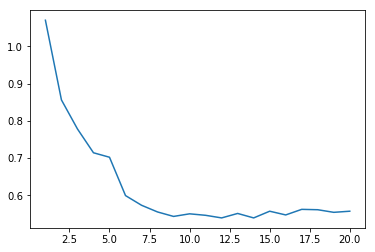

In [109]:
registered_or_casual='casual'
max_depth=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

rmse_list=[]
for i in max_depth:
    t0 = time()
    gb = GradientBoostingRegressor(
                      n_estimators=115,
                      learning_rate=0.05,
                      max_depth=i,                      
                      min_samples_leaf=20,
                      random_state=2)
    gb.fit(fe_train_data, train_data[registered_or_casual])
    predicted_y = gb.predict(fe_dev_data)
    rmse = get_RMSE(actual_values = dev_data[registered_or_casual], predicted_values = predicted_y)
    rmse_list.append(round(rmse,3))
    print row_format.format("max_depth", i, "RMSE", round(rmse,3),
                            "Runtime", round((time() - t0),3))
plt.plot(max_depth,rmse_list)
plt.show()

min_samples_leaf         1      RMSE     0.557   Runtime    10.503
min_samples_leaf         5      RMSE     0.566   Runtime     7.621


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in log


min_samples_leaf        10      RMSE     0.548   Runtime     6.031
min_samples_leaf        15      RMSE     0.545   Runtime     5.121
min_samples_leaf        20      RMSE      0.55   Runtime      4.57
min_samples_leaf        25      RMSE     0.546   Runtime     4.133
min_samples_leaf        30      RMSE     0.548   Runtime      3.76
min_samples_leaf        35      RMSE     0.584   Runtime     3.502


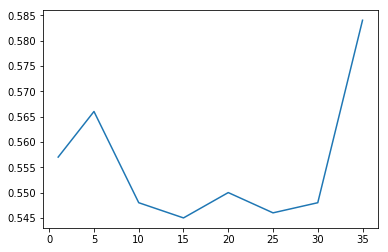

In [110]:
registered_or_casual='casual'
min_samples_leaf=[1,5,10,15,20,25,30,35]

rmse_list=[]
for i in min_samples_leaf:
    t0 = time()
    gb = GradientBoostingRegressor(
                      n_estimators=115,
                      learning_rate=0.05,
                      max_depth=10,                      
                      min_samples_leaf=i,
                      random_state=2)
    gb.fit(fe_train_data, train_data[registered_or_casual])
    predicted_y = gb.predict(fe_dev_data)
    rmse = get_RMSE(actual_values = dev_data[registered_or_casual], predicted_values = predicted_y)
    rmse_list.append(round(rmse,3))
    print row_format.format("min_samples_leaf", i, "RMSE", round(rmse,3),
                            "Runtime", round((time() - t0),3))
plt.plot(min_samples_leaf,rmse_list)
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log


n_estimator        70      RMSE     0.407   Runtime     2.945
n_estimator        75      RMSE      0.37   Runtime     3.115
n_estimator        80      RMSE     0.354   Runtime     3.304
n_estimator        85      RMSE     0.342   Runtime      3.35
n_estimator        90      RMSE     0.336   Runtime     3.508
n_estimator        95      RMSE     0.332   Runtime     3.651
n_estimator       100      RMSE     0.331   Runtime     3.806
n_estimator       105      RMSE     0.331   Runtime     3.935
n_estimator       110      RMSE     0.334   Runtime     4.055
n_estimator       115      RMSE     0.337   Runtime     4.201
n_estimator       120      RMSE     0.351   Runtime     4.298
n_estimator       125      RMSE     0.354   Runtime     4.388
n_estimator       130      RMSE     0.351   Runtime     4.551
n_estimator       135      RMSE     0.358   Runtime     4.667
n_estimator       140      RMSE     0.365   Runtime     4.784


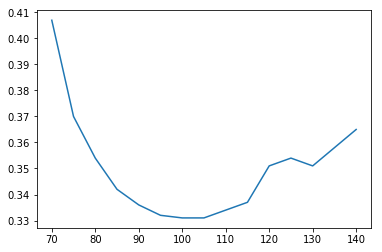

In [114]:
registered_or_casual='registered'
n_estimators=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140]

rmse_list=[]
for i in n_estimators:
    t0 = time()
    gb = GradientBoostingRegressor(
                      n_estimators=i,
                      learning_rate=0.05,
                      max_depth=10,                      
                      min_samples_leaf=20,
                      random_state=2)
    gb.fit(fe_train_data, train_data[registered_or_casual])
    predicted_y = gb.predict(fe_dev_data)
    rmse = get_RMSE(actual_values = dev_data[registered_or_casual], predicted_values = predicted_y)
    rmse_list.append(round(rmse,3))
    print row_format.format("n_estimator", i, "RMSE", round(rmse,3),
                            "Runtime", round((time() - t0),3))
plt.plot(n_estimators,rmse_list)
plt.show()